# Customer Segmentation/Clustering

## Import Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from datetime import datetime

## Data Loading and Preprocess

In [2]:
customers_df = pd.read_csv("../datasets/Customers.csv")
transactions_df = pd.read_csv("../datasets/Transactions.csv")

In [3]:
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [4]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


## Feature Engineering

In [5]:
# aggregate transactions data
transaction_summary = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': ['sum', 'mean'],
    'TransactionDate': ['min', 'max']
}).reset_index()

transaction_summary.head()

CustomerID TransactionID TotalValue               TransactionDate  \
                     count        sum     mean                  min   
0      C0001             5    3354.52  670.904   2024-01-19 3:12:55   
1      C0002             4    1862.74  465.685   2024-02-28 7:44:21   
2      C0003             4    2725.38  681.345   2024-02-18 2:50:37   
3      C0004             8    5354.88  669.360  2024-02-28 10:16:35   
4      C0005             3    2034.24  678.080   2024-03-15 4:08:59   

                        
                   max  
0  2024-11-02 17:04:16  
1   2024-12-03 1:41:41  
2  2024-08-24 18:54:04  
3  2024-12-23 14:13:52  
4   2024-11-04 0:30:22

In [6]:
transaction_summary.columns = [
    'CustomerID',
    'TotalTransactions',
    'TotalSpent',
    'AvgTransactionValue',
    'FirstPurchaseDate',
    'LastPurchaseDate'
    ]

In [7]:
# calculate how long a customer has been active with the company
transaction_summary['FirstPurchaseDate'] = pd.to_datetime(transaction_summary['FirstPurchaseDate'])
transaction_summary['LastPurchaseDate'] = pd.to_datetime(transaction_summary['LastPurchaseDate'])
transaction_summary['ActiveCustomerDuration'] = (transaction_summary['LastPurchaseDate'] - transaction_summary['FirstPurchaseDate']).dt.days

In [8]:
# Merge customers with transaction summary
customer_features = pd.merge(customers_df, transaction_summary, on='CustomerID')
customer_features.head()

,CustomerID,CustomerName,Region,SignupDate,TotalTransactions,TotalSpent,AvgTransactionValue,FirstPurchaseDate,LastPurchaseDate,ActiveCustomerDuration
0,C0001,Lawrence Carroll,South America,2022-07-10,5,3354.52,670.904,2024-01-19 03:12:55,2024-11-02 17:04:16,288
1,C0002,Elizabeth Lutz,Asia,2022-02-13,4,1862.74,465.685,2024-02-28 07:44:21,2024-12-03 01:41:41,278
2,C0003,Michael Rivera,South America,2024-03-07,4,2725.38,681.345,2024-02-18 02:50:37,2024-08-24 18:54:04,188
3,C0004,Kathleen Rodriguez,South America,2022-10-09,8,5354.88,669.360,2024-02-28 10:16:35,2024-12-23 14:13:52,299
4,C0005,Laura Weber,Asia,2022-08-15,3,2034.24,678.080,2024-03-15 04:08:59,2024-11-04 00:30:22,233


## Feature Preparation for Clustering

In [10]:
clustering_features = [
    'TotalTransactions',
    'TotalSpent',
    'AvgTransactionValue',
    'ActiveCustomerDuration'
]

X = customer_features[clustering_features]

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Determine Optimal number of Clusters

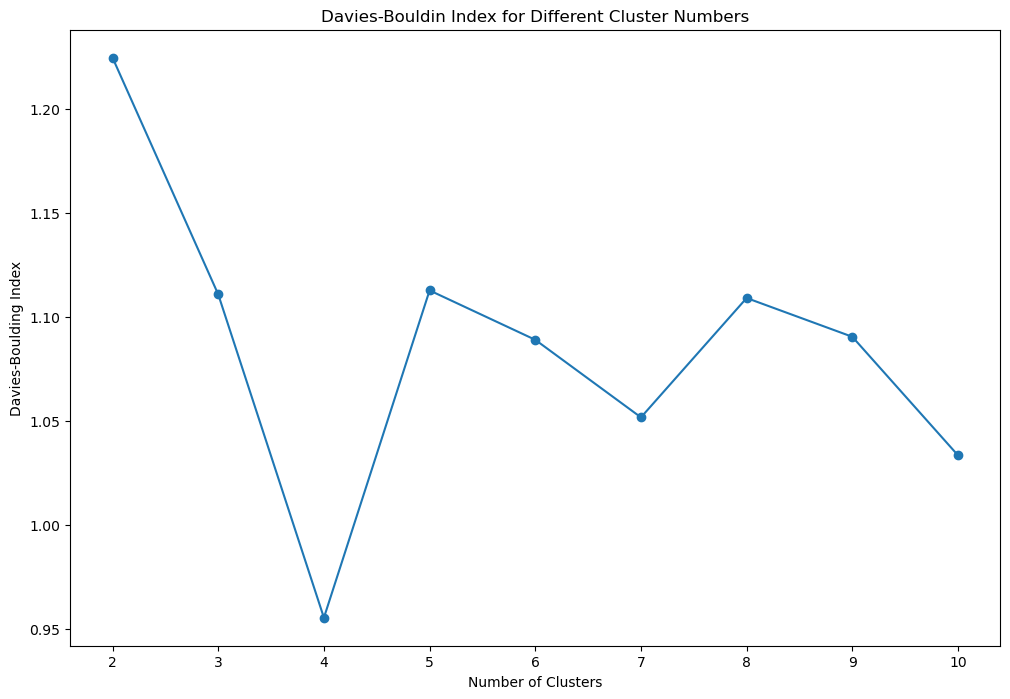

Optimal number of clusters is 4


In [13]:
# Evalute Clustering using Davies-Boulding Index
db_indices = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    db_indices.append(db_index)

# plot DB-Index
plt.figure(figsize=(12,8))
plt.plot(n_clusters_range, db_indices, marker='o')
plt.title('Davies-Bouldin Index for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Boulding Index')
plt.show()

optimal_clusters = n_clusters_range[np.argmin(db_indices)]
print(f"Optimal number of clusters is {optimal_clusters}")

## Perform Clustering

In [14]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X_scaled)

labels = customer_features['Cluster']
silhouette_score = silhouette_score(X_scaled, labels)
db_index = davies_bouldin_score(X_scaled, labels)

print("\nClustering Metrics:")
print(f"Davies-Boulding Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_score:.4f}")


Clustering Metrics:
Davies-Boulding Index: 0.9554
Silhouette Score: 0.3406


## Clusters Visualized

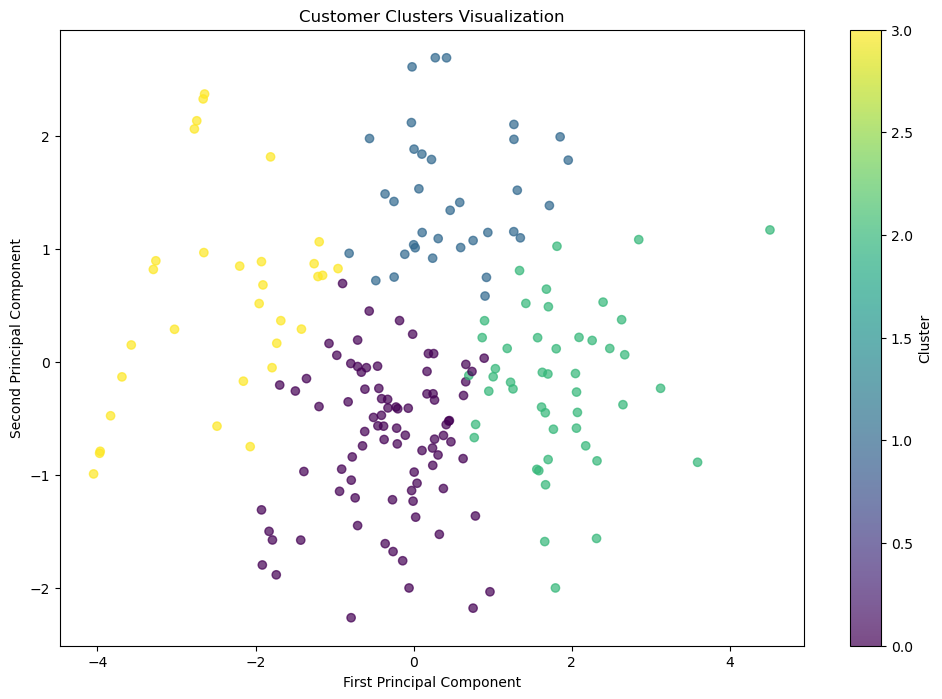

In [15]:
# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot
plt.figure(figsize=(12,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],
                      c = customer_features['Cluster'],
                      cmap='viridis', alpha=0.7)

plt.title('Customer Clusters Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

## Cluster Summary

In [18]:
cluster_summary = customer_features.groupby('Cluster')[clustering_features].mean()
print("\nCluster Characteristics:")
print(cluster_summary)


Cluster Characteristics:
         TotalTransactions   TotalSpent  AvgTransactionValue  \
Cluster                                                        
0                 4.837209  2626.356163           552.329999   
1                 4.371429  4404.216571          1023.230132   
2                 7.765957  5722.636596           743.660567   
3                 2.129032  1323.142903           598.805645   

         ActiveCustomerDuration  
Cluster                          
0                    257.546512  
1                    208.257143  
2                    284.446809  
3                     59.935484  


## Cluster Profiles

In [19]:
def cluster_profile(cluster_num):  
    cluster_data = customer_features[customer_features['Cluster'] == cluster_num]  
    
    print(f"\nCluster {cluster_num + 1} Profile:")  
    print("Total Customers:", len(cluster_data))  
    print("\nAverage Metrics:")  
    for feature in clustering_features:  
        print(f"{feature}: {cluster_data[feature].mean():.2f}")  
    
    # Region Distribution  
    region_dist = cluster_data['Region'].value_counts(normalize=True)  
    print("\nRegion Distribution:")  
    print(region_dist)  

In [20]:
cluster_profile(0)


Cluster 1 Profile:
Total Customers: 86

Average Metrics:
TotalTransactions: 4.84
TotalSpent: 2626.36
AvgTransactionValue: 552.33
ActiveCustomerDuration: 257.55

Region Distribution:
Region
South America    0.302326
North America    0.302326
Europe           0.232558
Asia             0.162791
Name: proportion, dtype: float64


In [21]:
cluster_profile(1)


Cluster 2 Profile:
Total Customers: 35

Average Metrics:
TotalTransactions: 4.37
TotalSpent: 4404.22
AvgTransactionValue: 1023.23
ActiveCustomerDuration: 208.26

Region Distribution:
Region
Europe           0.342857
South America    0.314286
North America    0.200000
Asia             0.142857
Name: proportion, dtype: float64


In [22]:
cluster_profile(2)


Cluster 3 Profile:
Total Customers: 47

Average Metrics:
TotalTransactions: 7.77
TotalSpent: 5722.64
AvgTransactionValue: 743.66
ActiveCustomerDuration: 284.45

Region Distribution:
Region
South America    0.319149
Asia             0.319149
Europe           0.191489
North America    0.170213
Name: proportion, dtype: float64


In [23]:
cluster_profile(3)


Cluster 4 Profile:
Total Customers: 31

Average Metrics:
TotalTransactions: 2.13
TotalSpent: 1323.14
AvgTransactionValue: 598.81
ActiveCustomerDuration: 59.94

Region Distribution:
Region
Asia             0.322581
Europe           0.290323
South America    0.225806
North America    0.161290
Name: proportion, dtype: float64
